In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import os
nltk.download('punkt')
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import colorcet as cc

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yehao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
allrecipe_df = pd.read_excel("./data/allrecipes_data.xlsx")
foodnetwork_df = pd.read_excel("./data/foodnetwork_data.xlsx")
kaggle_df = pd.read_csv("./data/kaggle_data.csv", index_col=0)

In [3]:
kaggle_df = kaggle_df[~kaggle_df['Instructions'].isna()]

In [4]:
df = pd.concat([allrecipe_df['food'], foodnetwork_df['food'], kaggle_df['Title']], axis=0).reset_index(drop=True)
recipe_names = df.values

In [5]:
recipe_names.shape

(49650,)

In [6]:
seen = set()
uniq = []
dups = {}
for name in recipe_names:
    if name not in seen:
        uniq.append(name)
        seen.add(name)
        dups[name] = 1
    else:
        dups[name] += 1
        
print("Unique recipes: ", len(uniq))
recipe_counts = sorted(dups.items(), key=lambda item: item[1], reverse=True)
print("Top 5 recipes: ", dict(recipe_counts[:5]))

Unique recipes:  48909
Top 5 recipes:  {'French 75': 5, 'Potato Latkes': 5, 'Banana Bread': 4, 'Daiquiri': 4, 'Manhattan': 4}


In [7]:
processed_names = []
stemmer = SnowballStemmer("english")
stopwords_list = stopwords.words("english")

for name in recipe_names:
    if not isinstance(name, str):
        name = str(name)
    else:
        name = name.lower()
        
    tokens = word_tokenize(name)
    filtered_words = [word for word in tokens if word.isalpha() and word not in stopwords_list]
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    
    processed_names.append(stemmed_words)     

processed_names[:10]

[['air', 'fryer', 'chicken', 'thigh'],
 ['air', 'fryer', 'heart', 'palm', 'stick'],
 ['air', 'fryer', 'spanakopita'],
 ['air', 'fryer', 'pecan', 'crust', 'trout'],
 ['air', 'fryer', 'tempura', 'veget'],
 ['air', 'fryer', 'roast', 'veget', 'gremolata', 'red', 'pepper', 'aioli'],
 ['crab', 'rangoon', 'air', 'fryer'],
 ['air', 'fryer', 'crispi', 'pickl', 'chip', 'creol', 'dip', 'sauc'],
 ['air', 'fryer', 'chicken', 'tender'],
 ['air', 'fryer', 'chicken', 'strip']]

In [8]:
dictionary = corpora.Dictionary(processed_names)
print(dictionary)

Dictionary<8223 unique tokens: ['air', 'chicken', 'fryer', 'thigh', 'heart']...>


In [9]:
# Convert dictionary to a Bag of Words corpus
corpus = [dictionary.doc2bow(name) for name in processed_names]
# (0, 1) means word at index 0 appeared one time
corpus[:5]

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (2, 1), (4, 1), (5, 1), (6, 1)],
 [(0, 1), (2, 1), (7, 1)],
 [(0, 1), (2, 1), (8, 1), (9, 1), (10, 1)],
 [(0, 1), (2, 1), (11, 1), (12, 1)]]

In [10]:
lda_model = models.LdaModel(corpus, num_topics=40, id2word=dictionary, passes=1)

In [11]:
topics = lda_model.print_topics(num_topics=40, num_words=5)
topics[:5]

[(0,
  '0.332*"appl" + 0.290*"corn" + 0.065*"tuna" + 0.054*"oatmeal" + 0.031*"basic"'),
 (1,
  '0.372*"chocol" + 0.240*"cooki" + 0.083*"eggplant" + 0.057*"chip" + 0.026*"waffl"'),
 (2,
  '0.253*"lamb" + 0.177*"white" + 0.172*"chop" + 0.119*"zucchini" + 0.060*"coffe"'),
 (3,
  '0.403*"cake" + 0.113*"carrot" + 0.072*"beet" + 0.060*"wild" + 0.050*"cupcak"'),
 (4,
  '0.438*"roast" + 0.170*"pepper" + 0.081*"arugula" + 0.074*"avocado" + 0.069*"cauliflow"')]

In [12]:
lda_coherence_model = CoherenceModel(model=lda_model, texts=processed_names, coherence='c_v')
lda_coherence = lda_coherence_model.get_coherence()

print("LDA Coherence:", lda_coherence)

LDA Coherence: 0.5868894139162791


In [13]:
recipes_with_topics = []
topic_distributions = []

for recipe_i in range(len(recipe_names)):
    # Get the topic distribution for the given recipe
    topic_distribution = lda_model.get_document_topics(corpus[recipe_i])
    topic_distributions.append(topic_distribution)
    
    sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)
    most_probable_topic = sorted_topics[0][0] if sorted_topics else None
    recipes_with_topics.append((recipe_names[recipe_i], most_probable_topic))

df_recipes_with_topics = pd.DataFrame(recipes_with_topics, columns=['Recipe Name', 'Assigned Topic'])

In [14]:
df_recipes_with_topics

,Recipe Name,Assigned Topic
0,Air Fryer Honey-Mustard Chicken Thighs,13
1,Air Fryer Hearts of Palm Sticks,33
2,Air Fryer Spanakopita,13
3,Air Fryer Pecan Crusted Trout,10
4,Air Fryer Tempura Vegetables,13
...,...,...
49645,Brownie Pudding Cake,3
49646,Israeli Couscous with Roasted Butternut Squash...,11
49647,Rice with Soy-Glazed Bonito Flakes and Sesame ...,35
49648,Spanakopita,35


In [15]:
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

In [16]:
num_docs = len(corpus)
num_topics = lda_model.num_topics
matrix = np.zeros((num_docs, num_topics))

for doc_idx, doc_topics in enumerate(topic_distributions):
    for topic, prob in doc_topics:
        matrix[doc_idx, topic] = prob

In [17]:
tsne_model = TSNE(n_components=2, random_state=42)
tsne_matrix = tsne_model.fit_transform(matrix)

In [18]:
palette = sns.color_palette(cc.glasbey, n_colors=40)

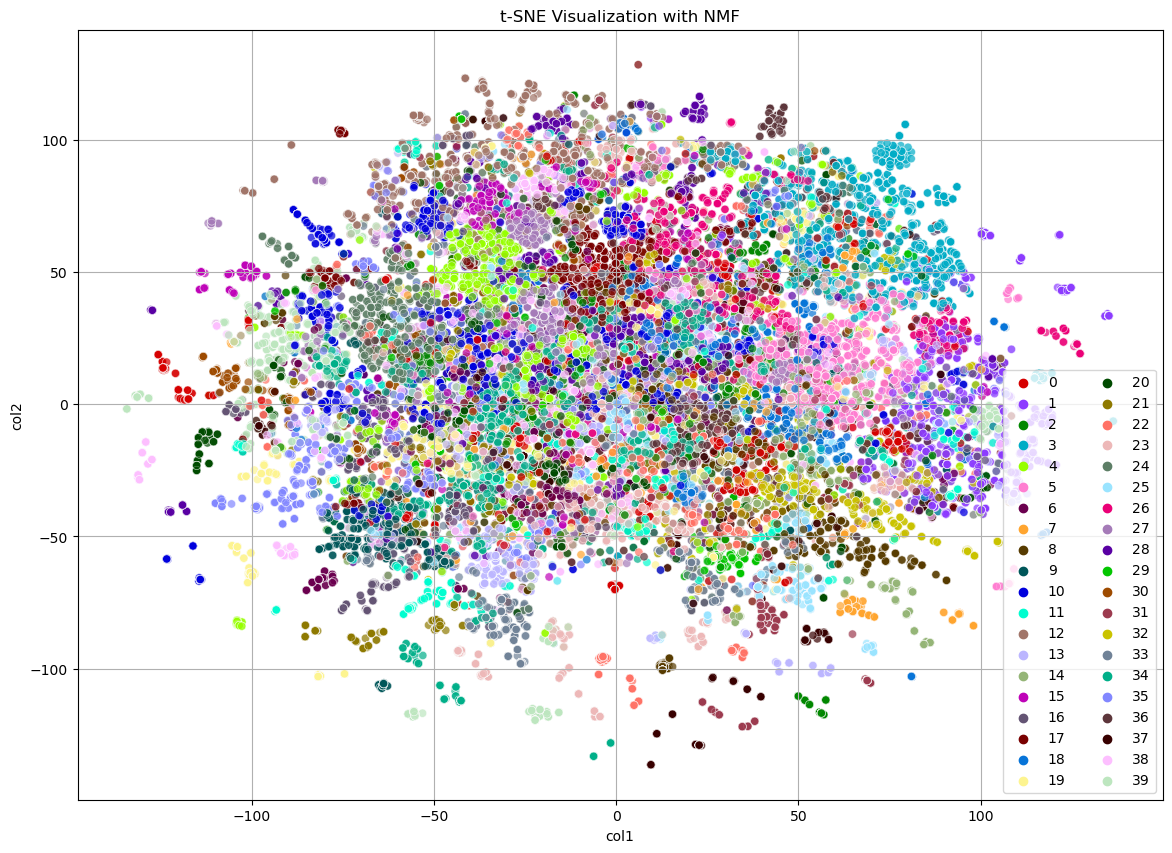

In [19]:
df = pd.DataFrame(tsne_matrix, columns=['col1', 'col2'])
df['labels'] = df_recipes_with_topics['Assigned Topic']

plt.figure(figsize=(14, 10))
sns.scatterplot(x='col1', y='col2', hue='labels', data=df, palette=palette, alpha=0.7)
plt.title('t-SNE Visualization with NMF')
plt.legend(ncol=2)
plt.grid()
plt.show()

In [20]:
labels = df_recipes_with_topics['Assigned Topic']
label_counts = Counter(labels)

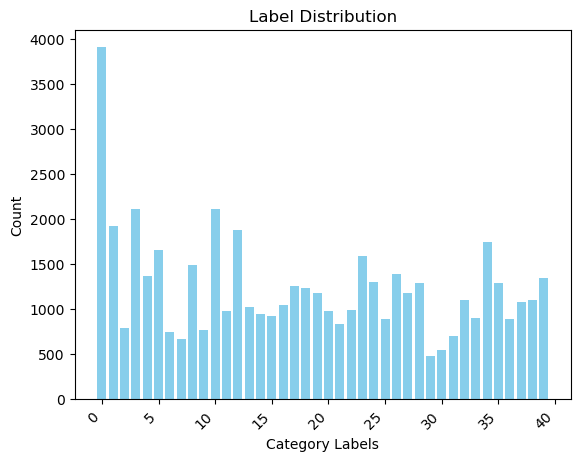

In [21]:
lab, counts = zip(*label_counts.items())

plt.bar(lab, counts, color='skyblue')
plt.xlabel('Category Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

In [28]:
allrecipt_imageDirs = []
kaggle_imageDirs = []
foodnetwork_imageDirs = []

for i in range(allrecipe_df.shape[0]):
    allrecipt_imageDirs.append('./data/images/allrecipes_images/image_' + str(i) + '.jpg')

for index, row in foodnetwork_df.iterrows():
    image_name = row['images'].split('/')[-1] or f'image_{index}.jpg'
    foodnetwork_imageDirs.append('./data/images/foodnetwork_images/' + image_name)
    
for imgName in kaggle_df['Image_Name']:
    kaggle_imageDirs.append('./data/images/kaggle_images/' + imgName + '.jpg')

all_imageDirs = allrecipt_imageDirs + foodnetwork_imageDirs + kaggle_imageDirs

dataset = []
# badList = ['./foodnetwork_images/foodnetwork_images/1677268264252.jpeg',
#            './foodnetwork_images/foodnetwork_images/1382967555384.jpeg']

for i in range(len(all_imageDirs)):
    try:
    #     if os.path.exists(all_imageDirs[i]) and all_imageDirs[i] not in badList:
        if os.path.exists(all_imageDirs[i]) and Image.open(all_imageDirs[i]):
            dataset.append((all_imageDirs[i], recipes_with_topics[i][1]))
    except:
        print(f"invalid image path {all_imageDirs[i]}")
        
np.save('./data/interim/LDA_dataset', dataset)

invalid image path ./data/images/foodnetwork_images/1677268264252.jpeg
invalid image path ./data/images/foodnetwork_images/1382967555384.jpeg


In [29]:
len(dataset)

49540

## Pre-load dataset

In [30]:
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import pickle 

In [31]:
dataset = np.load('./data/interim/LDA_dataset.npy')
train_dataset, test_dataset = train_test_split(dataset, train_size=0.85 , random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, train_size=0.8 , random_state=42)

In [32]:
def load_dataset(dataset):
    dataset = dataset.tolist()
    for i in range(len(dataset)):
        if (i+1) % 100 == 0:
            print('loading image {} of {}'.format(i+1, len(dataset)))
        image = Image.open(dataset[i][0])
        image = image.resize((224, 224))  # Resize image to 112x112 (adjust as needed)
        image = image.convert('RGB')
        image = np.array(image)
        image = np.transpose(image, (2, 0, 1))
        image = image / 255.0
        image_tensor = torch.tensor(image, dtype=torch.float32)
        dataset[i].append(image_tensor)

    return dataset        

In [33]:
train_dataset = load_dataset(train_dataset)
val_dataset = load_dataset(val_dataset)
test_dataset = load_dataset(test_dataset)

with open(f'./data/processed/LDA_train.pkl', 'wb') as f:
        pickle.dump(train_dataset, f)
with open(f'./data/processed/LDA_val.pkl', 'wb') as f:
        pickle.dump(val_dataset, f)
with open(f'./data/processed/LDA_test.pkl', 'wb') as f:
        pickle.dump(test_dataset, f)

loading image 100 of 33687
loading image 200 of 33687
loading image 300 of 33687
loading image 400 of 33687
loading image 500 of 33687
loading image 600 of 33687
loading image 700 of 33687
loading image 800 of 33687
loading image 900 of 33687
loading image 1000 of 33687
loading image 1100 of 33687
loading image 1200 of 33687
loading image 1300 of 33687
loading image 1400 of 33687
loading image 1500 of 33687
loading image 1600 of 33687
loading image 1700 of 33687
loading image 1800 of 33687
loading image 1900 of 33687
loading image 2000 of 33687
loading image 2100 of 33687
loading image 2200 of 33687
loading image 2300 of 33687
loading image 2400 of 33687
loading image 2500 of 33687
loading image 2600 of 33687
loading image 2700 of 33687
loading image 2800 of 33687
loading image 2900 of 33687
loading image 3000 of 33687
loading image 3100 of 33687
loading image 3200 of 33687
loading image 3300 of 33687
loading image 3400 of 33687
loading image 3500 of 33687
loading image 3600 of 33687
l

loading image 28800 of 33687
loading image 28900 of 33687
loading image 29000 of 33687
loading image 29100 of 33687
loading image 29200 of 33687
loading image 29300 of 33687
loading image 29400 of 33687
loading image 29500 of 33687
loading image 29600 of 33687
loading image 29700 of 33687
loading image 29800 of 33687
loading image 29900 of 33687
loading image 30000 of 33687
loading image 30100 of 33687
loading image 30200 of 33687
loading image 30300 of 33687
loading image 30400 of 33687
loading image 30500 of 33687
loading image 30600 of 33687
loading image 30700 of 33687
loading image 30800 of 33687
loading image 30900 of 33687
loading image 31000 of 33687
loading image 31100 of 33687
loading image 31200 of 33687
loading image 31300 of 33687
loading image 31400 of 33687
loading image 31500 of 33687
loading image 31600 of 33687
loading image 31700 of 33687
loading image 31800 of 33687
loading image 31900 of 33687
loading image 32000 of 33687
loading image 32100 of 33687
loading image 